In [87]:
!pip install yfinance

## Stock DATASET

In [88]:
from torch.utils.data import Dataset, DataLoader
from typing import Union
import torch
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [89]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)//self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+1]
        # sample = self.data['Close'][index:index+self.nb_samples+1]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample

        sample = sample[:-1] # removes label from sample
        return sample, label

def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :


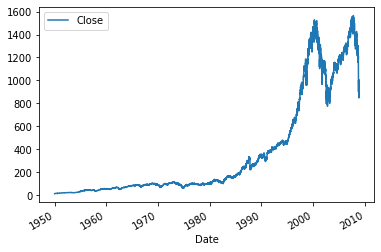

In [90]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d', 
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  date = dataset.data.plot(None, ['Close'])

## Modèle

In [91]:
from torch.nn import LSTM, Module, Dropout, ModuleList

In [92]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True, proj_size = 1)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]
    

## Configuration

In [93]:
class StockAIConfig():
    config = {
        "model":{
            "input_size": 1,
            "lstm_size": 128,
            "num_layers": 1,
            "keep_prob": 0.5
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2008-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":True
        },
        "dataset_test":{
            "start_date": '2008-11-17',
            "end_date": '2021-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":False
        },

        "learning":{
            "num_steps": 30,
            "init_lr": 1e-03,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 50
        }   
    }

##Prediction : Train / Test

In [94]:
import math
import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.optim import RMSprop

In [95]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

# Init of the Dataset_test
dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_test"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of Dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], config["dataset_test"]["shuffle"], drop_last=True)

# Init of the model
model = StockAI(config["model"]["input_size"],
                config["model"]["lstm_size"],
                config["model"]["num_layers"],
                config["model"]["keep_prob"])

model.to(device)

# Learning rate to use along the epochs
learning_rates = [config["learning"]["init_lr"] * (config["learning"]["lr_decay"] ** max(float(i + 1 - config["learning"]["init_epoch"]), 0.0)) for i in range(config["learning"]["max_epoch"])]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rates[0], eps=1e-08)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [96]:
len(dataloader_train)

15

In [97]:
# Learning
for epoch_step in range(config["learning"]["max_epoch"]):
    lr = learning_rates[epoch_step]
    print(f"Running for epoch {epoch_step}...")
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = torch.squeeze(model.forward(x))
        loss = loss_fn(y_pred, y)

        if i_batch%60==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Running for epoch 0...
step: 0, loss = 1.089455008506775
Running for epoch 1...
step: 0, loss = 0.0006068057846277952
Running for epoch 2...
step: 0, loss = 0.000888632726855576
Running for epoch 3...
step: 0, loss = 0.0006809783517383039
Running for epoch 4...
step: 0, loss = 0.0007198263774625957
Running for epoch 5...
step: 0, loss = 0.0005232839612290263
Running for epoch 6...
step: 0, loss = 0.0005080535192973912
Running for epoch 7...
step: 0, loss = 0.0005095957312732935
Running for epoch 8...
step: 0, loss = 0.00046101256157271564
Running for epoch 9...
step: 0, loss = 0.000713794375769794
Running for epoch 10...
step: 0, loss = 0.0003462353197392076
Running for epoch 11...
step: 0, loss = 0.0005397640634328127
Running for epoch 12...
step: 0, loss = 0.0005895645590499043
Running for epoch 13...
step: 0, loss = 0.0006002537556923926
Running for epoch 14...
step: 0, loss = 0.0021731294691562653
Running for epoch 15...
step: 0, loss = 0.0011724201031029224
Running for epoch 16...

In [98]:
#test
runnning_mape = 0
for i_batch, batch in enumerate(dataloader_test):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = torch.squeeze(model.forward(x))
        error = torch.mean(torch.abs((y - y_pred) / y))
        runnning_mape += error

mape = runnning_mape / len(dataloader_test)
print("",mape)

 tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>)


In [99]:
import matplotlib.pyplot as plt

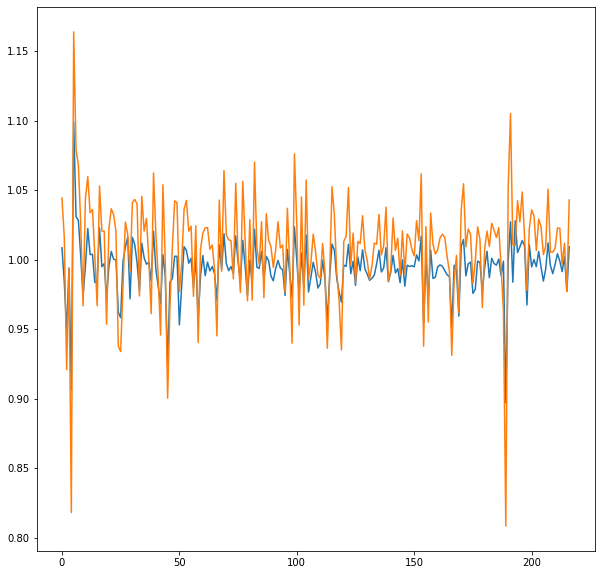

In [100]:
p = dataset_test.__len__()
pred = list()
truth = list()
for i in range(p-1):
  x, y = dataset_test.__getitem__(i)
  x = torch.unsqueeze(torch.unsqueeze(x, -1),0).float()
  x = x.to(device)
  truth.append(y)
  res = torch.squeeze(model.forward(x))
  pred.append(res)

plt.figure(figsize=(10,10))
plt.plot(pred)
plt.plot(truth)

plt.show()